# George_PLOT_Fig2

A notebook to plot Fig.2 using George results ... Because calculating the expectation value results is so slow  for George I just have the MAP results, that's why I don't ust use `NOX_Plot_...ipynb`

In [2]:
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
import os
import scipy

In [3]:
# read in the files  with logL evaluated on a grid
# and calculate the expectation value .... 

engine = 'celerite'#'george'#'celerite'# 'george'# 'george'  # 'celerite' 
expectation = True # did we do MAP and expectation or MAP only ? 
where = '/190208_results_celerite/' #/190208_George_MAP/'#'/190208_results_celerite/'#/180619_tuesday_work/'#'/190208_George_MAP/' # '/190207_results_celerite/'# 180619_tuesday_work/'#/190207_George_MAP/'
#Celerite : '/190207_results_celerite/'#
#Celetite : '/180619_tuesday_work/'

for simulation in ['OGLE','SDSS']:#, 'OGLE']: 
    if simulation is 'SDSS':
        N = 60
    if simulation is 'OGLE':
        N = 445
    resDir  = '../data_products/Simulated_DRW_Kozlowski/'+\
             simulation+where 
        
    # read the list of save files 
    files = os.listdir(resDir)
    print('For  ', simulation, ', using ', len(files), ' files')
    
    # initialize storage dic
    store_results = {'lc_name': np.zeros_like(files)}
    
    # given that each savefile is a dictionary
    # use it's keys to create the appropriate 
    # storage dicts given the first file 
    # on the list ... 
    results = np.load(resDir+files[0]).item()
    priors  = list(results.keys())
    print('    Used priors were ', priors )
    for key in results[priors[0]].keys(): 
        store_results[key] = np.zeros(len(files), dtype=float)
        
    # initialize the rho_grid... 
    rho_min, rho_max,  n_rho = 0.001, 15, 100
    rho_grid = np.logspace(np.log10(rho_min), np.log10(rho_max), n_rho)

    for prior in  priors:
        for k in range(len(files)) : 
            fname = files[k]
            # save the lcname 
            store_results['lc_name'][k] = fname[:-9] + '.dat'
            
            # read in the results for this light curve 
            results = np.load(resDir+fname).item()

            # recover rho and tau : input parameters 
            store_results['rho_in'][k] = results[prior]['rho_in']
            store_results['tau_in'][k] = results[prior]['tau_in']

            # read the MAP results 
            store_results['sigma_MAP'][k] = results[prior]['sigma_MAP']
            store_results['tau_MAP'][k] = results[prior]['tau_MAP']

            if expectation : 
                # we are storing log Posterior ...
                logP = results[prior]['logPosterior']

                # we also store the actual grid....
                sigma_grid = results[prior]['sigma_grid']
                tau_grid   = results[prior]['tau_grid']

                # read the expectation value ... 
                # computed using mod.find_expectation_value()
                store_results['sigma_EXP'][k] = results[prior]['sigma_EXP']
                store_results['tau_EXP'][k]   = results[prior]['tau_EXP']

        # store for each prior  prior...
        store = Table(store_results)
        fname  = engine+'_'+prior+'_'+str(int(N))+'_'+simulation+'.txt'
        print('    Saved as ', fname)
        store.write(fname, format='ascii',overwrite=True)



For   OGLE , using  10000  files
    Used priors were  ['Jeff1', 'Jeff2']
    Saved as  celerite_Jeff1_445_OGLE.txt
    Saved as  celerite_Jeff2_445_OGLE.txt
For   SDSS , using  10000  files
    Used priors were  ['Jeff1', 'Jeff2']
    Saved as  celerite_Jeff1_60_SDSS.txt
    Saved as  celerite_Jeff2_60_SDSS.txt


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10


Saved as  celerite_OGLE_Jeff1_MAP-190208_results_celerite.png
Saved as  celerite_OGLE_Jeff1_expectation-190208_results_celerite.png


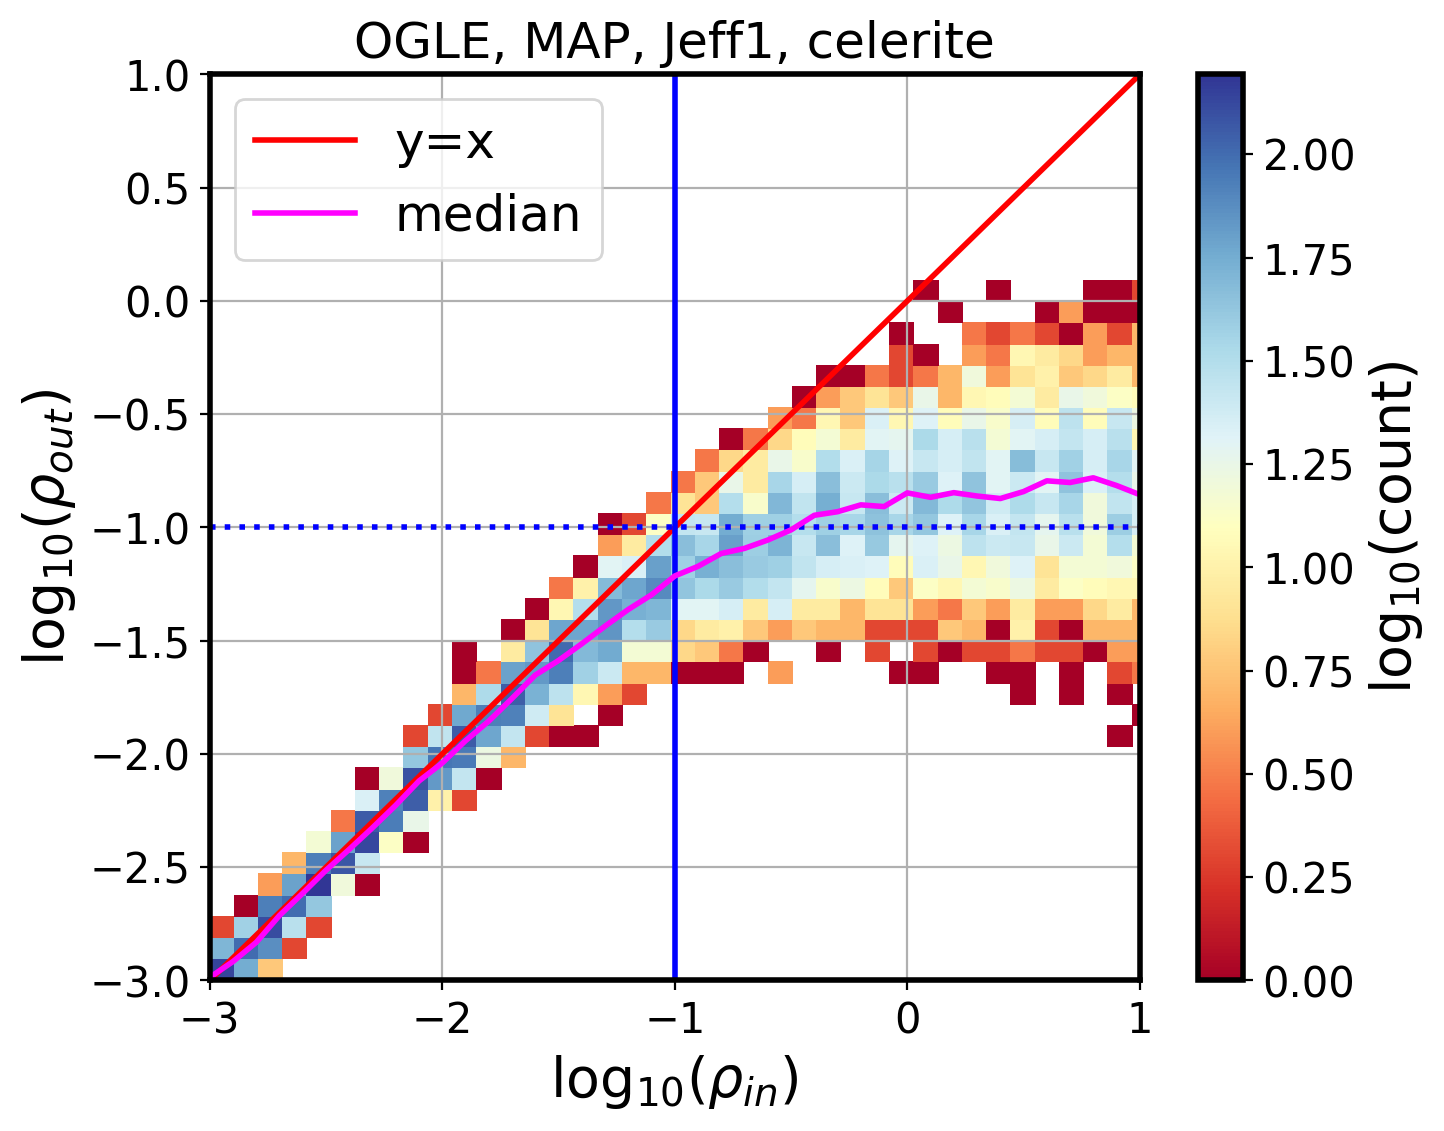

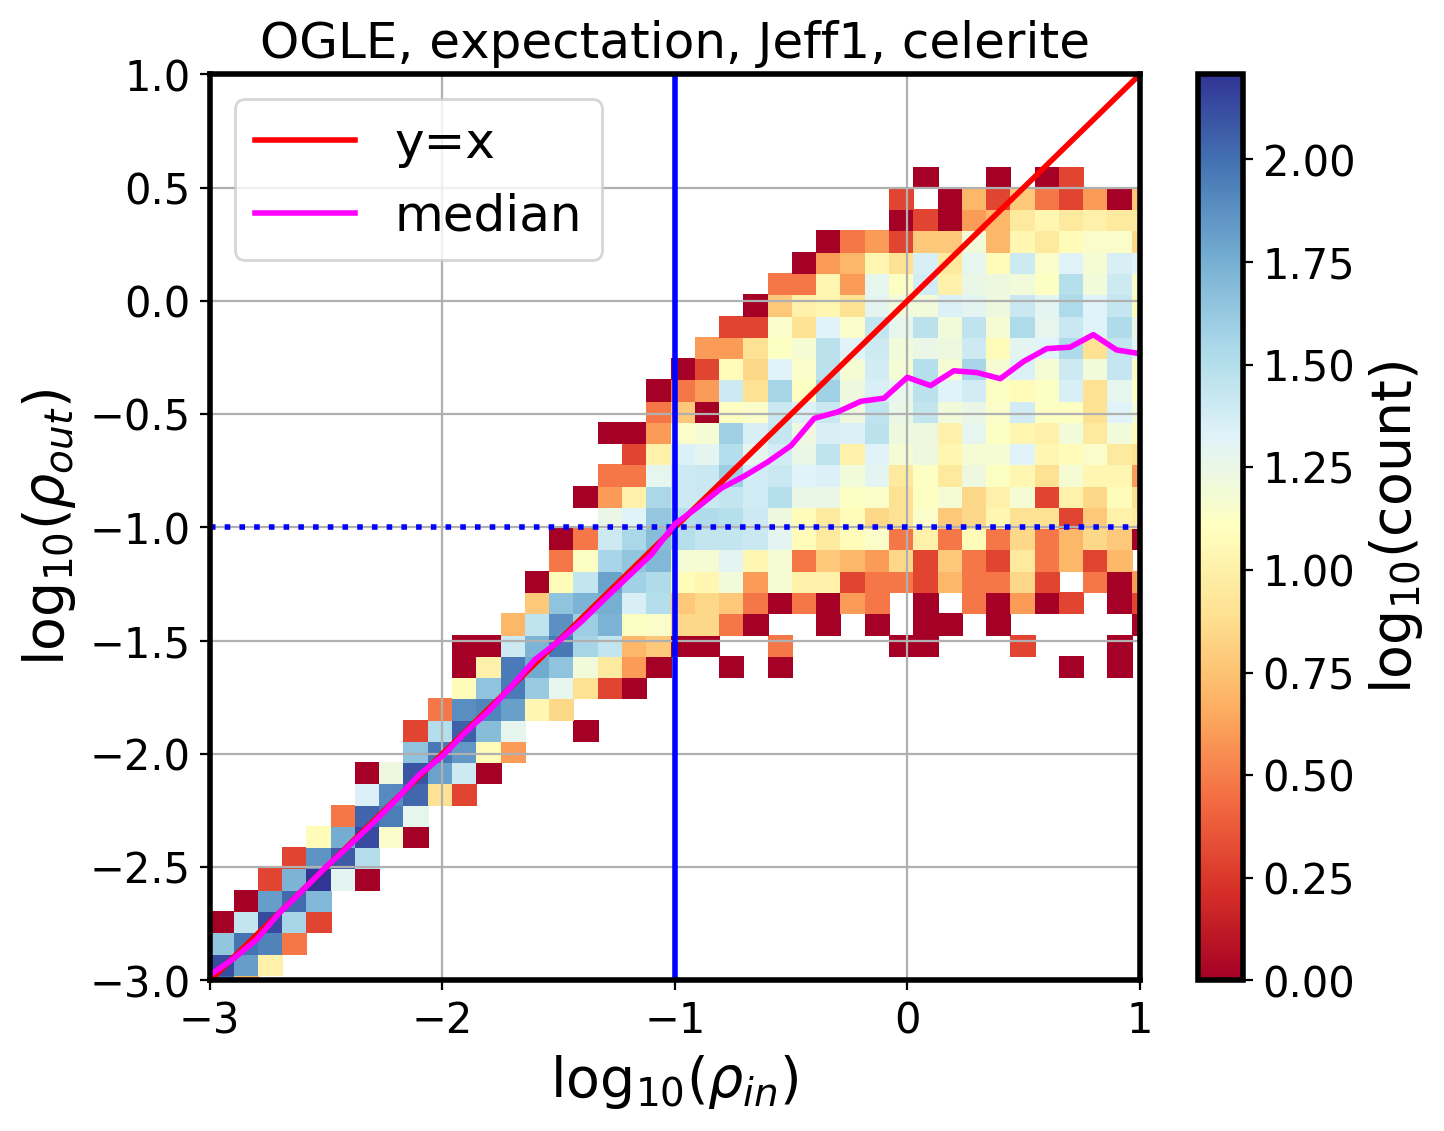

In [5]:
%matplotlib inline
from scipy.stats import binned_statistic_2d

prior='Jeff1'  
# Jeff1 is 1/sigma * 1/tau 
simulation= 'OGLE'#'SDSS'#'OGLE'# 'SDSS'

if simulation is 'SDSS':
    N = 60
if simulation is 'OGLE':
    N = 445 

fname = engine+'_'+prior+'_'+str(int(N))+'_'+simulation+'.txt'
store = Table.read(fname, format='ascii')

%config InlineBackend.figure_format='retina'
#fig = plt.figure(figsize=(10, 5), dpi=100)

t_exp = 8 * 365.0 # days 
rho_in = store['rho_in']


if expectation : 
    labels = ['MAP', 'expectation']
else : 
    labels = ['MAP']
for label in labels:
    if label is 'MAP':
        rho_out  = store['tau_MAP']/t_exp #* np.power(10,0.16)
    elif label is 'expectation':
        rho_out  = store['tau_EXP'] / t_exp
        
    fig,ax = plt.subplots(1,1,figsize=(7.5,6), dpi=100)
    x = np.log10(rho_in)
    y = np.log10(rho_out)

    stats = binned_statistic_2d(x, y, x, statistic='count', bins=40)
    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
    image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                             cmap=plt.cm.get_cmap('RdYlBu'))
    # labels...
    ax.set_xlabel(r'$\log_{10}(\rho_{in})$')
    ax.set_ylabel(r'$\log_{10}(\rho_{out})$')

    plt.colorbar(image, label=r'$\log_{10}{(\mathrm{count})}$')
    # lines to guide the eye ...
    ax.grid()
    xlim = ax.get_xlim()
    x_line = np.arange(xlim[0], xlim[1],0.01)
    ax.plot(x_line,x_line, ls='-', lw=2, color='red', label='y=x')
    ax.axhline(-1, ls=':', lw=2, c='blue')
    ax.axvline(-1, ls='-', lw=2, c='blue')

    # calculate the median of log(rho_out)
    # Median of the log(y) is not the log(median(y)) .... 
    min_x, max_x , step_size = xlim[0],xlim[1], 0.1
    mean_x = np.arange(min_x, max_x+step_size , step_size)
    dx = 0.5 * step_size 
    median_y = np.zeros(len(mean_x))

    for j in range(len(median_y)):
        # take points that are within desired x_data limits for each bin
        # i.e. marginalize along y ( stack vertically)
        mask =  ((mean_x[j] - dx) < x)*(x<  (mean_x[j] + dx))
        median_y[j] = np.median(y[mask])

    ax.plot(mean_x[:-1], median_y[:-1], c = 'magenta',lw=2, label='median')#, s=50 , edgecolor='black')
    ax.legend(fontsize=18)
    ax.set_title(simulation+', '+label +', '+ prior+', '+engine)
    ax.set_ylim(-3,1)
    ax.set_xlim(-3,1)
    figname = engine+'_'+simulation+'_'+prior+'_'+label+'-'+where[1:-1]+'.png'
    plt.savefig(figname, bbox_inches='tight')
    print('Saved as ', figname)

Edit that plot :  flip left to right , and top to bottom ... Also plot only Jeff1, Expectation, OGLE and SDSS, since these are the ones that we use in the end ... 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10


Saved as  celerite_SDSS_Jeff1_expectation-190208_results_celerite_R.png


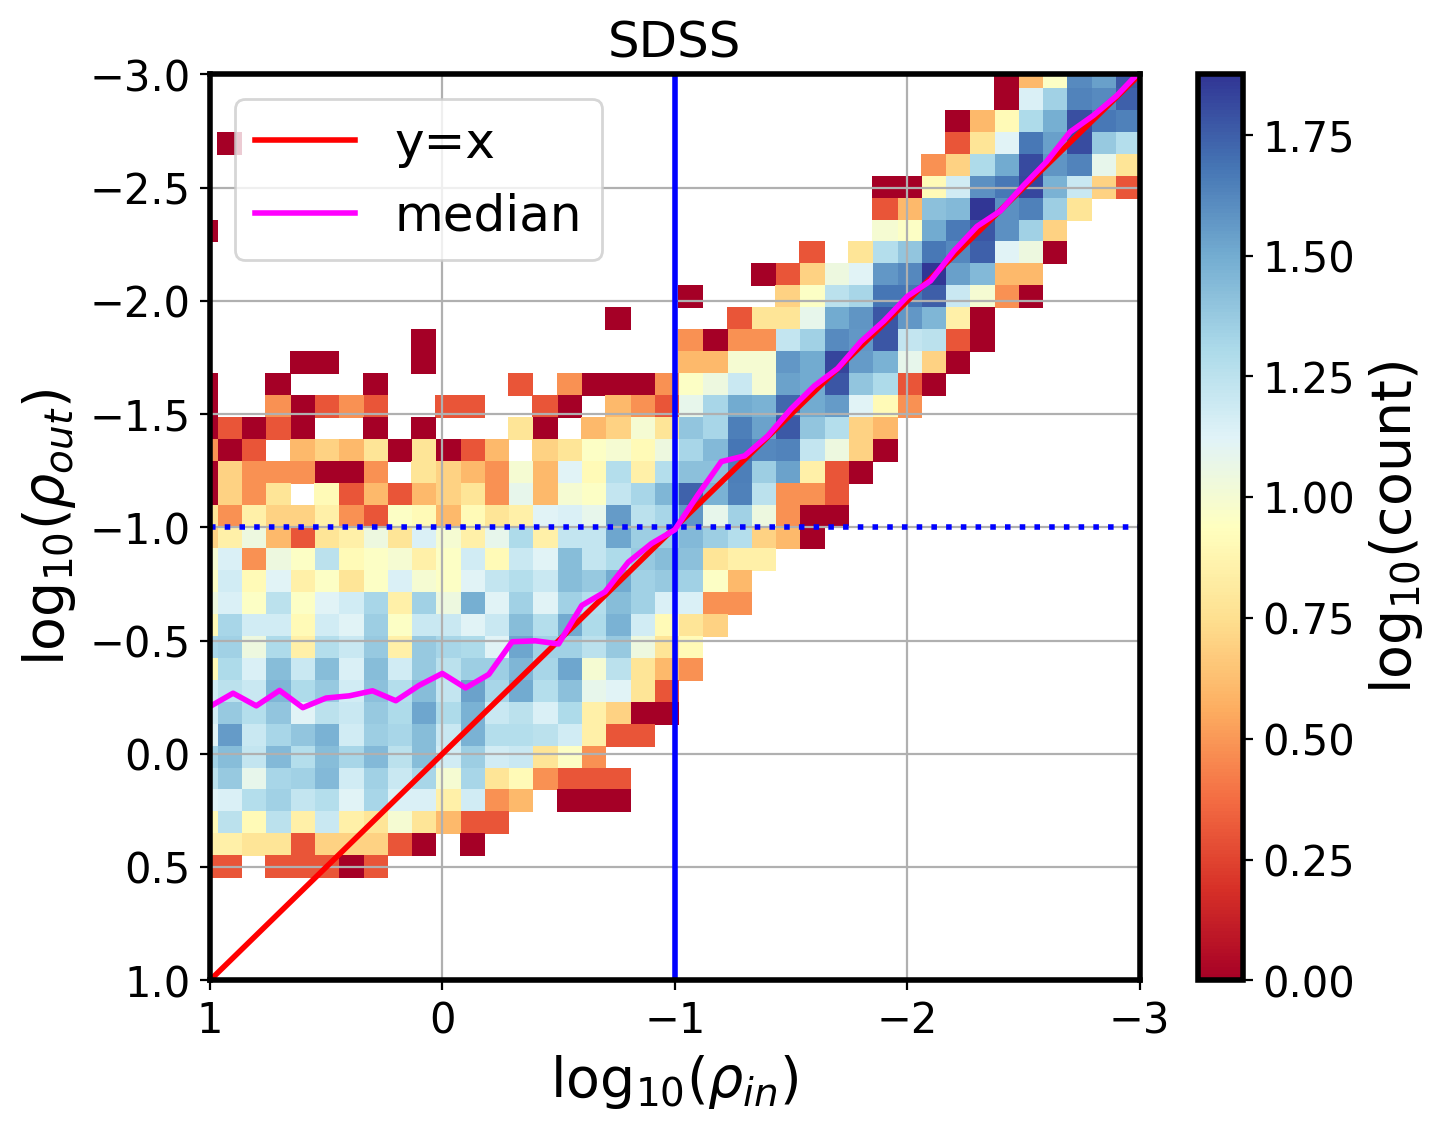

In [8]:
%matplotlib inline
from scipy.stats import binned_statistic_2d

prior='Jeff1'  
# Jeff1 is 1/sigma * 1/tau 
simulation= 'SDSS'#'OGLE'#'SDSS'#'OGLE'# 'SDSS'

if simulation is 'SDSS':
    N = 60
if simulation is 'OGLE':
    N = 445 
engine = 'celerite'
fname = engine+'_'+prior+'_'+str(int(N))+'_'+simulation+'.txt'
store = Table.read(fname, format='ascii')

%config InlineBackend.figure_format='retina'
#fig = plt.figure(figsize=(10, 5), dpi=100)

t_exp = 8 * 365.0 # days 
rho_in = store['rho_in']

label = 'expectation'
rho_out  = store['tau_EXP'] / t_exp
        
fig,ax = plt.subplots(1,1,figsize=(7.5,6), dpi=100)
x = np.log10(rho_in)
y = np.log10(rho_out)

stats = binned_statistic_2d(x, y, x, statistic='count', bins=40)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                         cmap=plt.cm.get_cmap('RdYlBu'))

plt.colorbar(image, label=r'$\log_{10}{(\mathrm{count})}$')
# lines to guide the eye ...
ax.grid()
xlim = ax.get_xlim()
x_line = np.arange(xlim[0], xlim[1],0.01)
ax.plot(x_line,x_line, ls='-', lw=2, color='red', label='y=x')
ax.axhline(-1, ls=':', lw=2, c='blue')
ax.axvline(-1, ls='-', lw=2, c='blue')

# calculate the median of log(rho_out)
# Median of the log(y) is not the log(median(y)) .... 
min_x, max_x , step_size = xlim[0],xlim[1], 0.1
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size 
median_y = np.zeros(len(mean_x))

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  ((mean_x[j] - dx) < x)*(x<  (mean_x[j] + dx))
    median_y[j] = np.median(y[mask])

ax.plot(mean_x[:-1], median_y[:-1], c = 'magenta',lw=2, label='median')#, s=50 , edgecolor='black')
# labels...
ax.set_xlabel(r'$\log_{10}(\rho_{in})$')
ax.set_ylabel(r'$\log_{10}(\rho_{out})$')
ax.legend(fontsize=18)
ax.set_title(simulation)
ax.set_ylim(-3,1)
ax.set_xlim(-3,1)
ax.invert_xaxis()
ax.invert_yaxis()
figname = engine+'_'+simulation+'_'+prior+'_'+label+'-'+where[1:-1]+'_R.png'
plt.savefig(figname, bbox_inches='tight')
print('Saved as ', figname)

Using the $\rho_{out}$,  $\rho_{in}$  from Fig.2 for SDSS-like cadence and errors, plot the distribution of $\rho_{in}$ that could produce a given  combination of $\rho_{out}$, i.e. $\tau_{fit}$ and baseline .  

First, for the results of simulated :  given the results from simulated LCs ( a set of $\tau_{fit}$ and baselines ) , what $\rho_{in}$ could produce it  ? Then do the same for real data ... 

In [11]:
%config InlineBackend.figure_format='retina'

prior='Jeff1'   # Jeff1 is 1/sigma * 1/tau 
simulation= 'SDSS' ; N = 60 ;  engine = 'celerite'
fname = engine+'_'+prior+'_'+str(int(N))+'_'+simulation+'.txt'
store = Table.read(fname, format='ascii')

t_exp = 8 * 365.0 # days 
rho_in = store['rho_in']

label = 'expectation'
rho_out  = store['tau_EXP'] / t_exp

x = np.log10(rho_in)
y = np.log10(rho_out)



Text(0, 0.5, '$\\log_{10}(\\rho_{out})$')

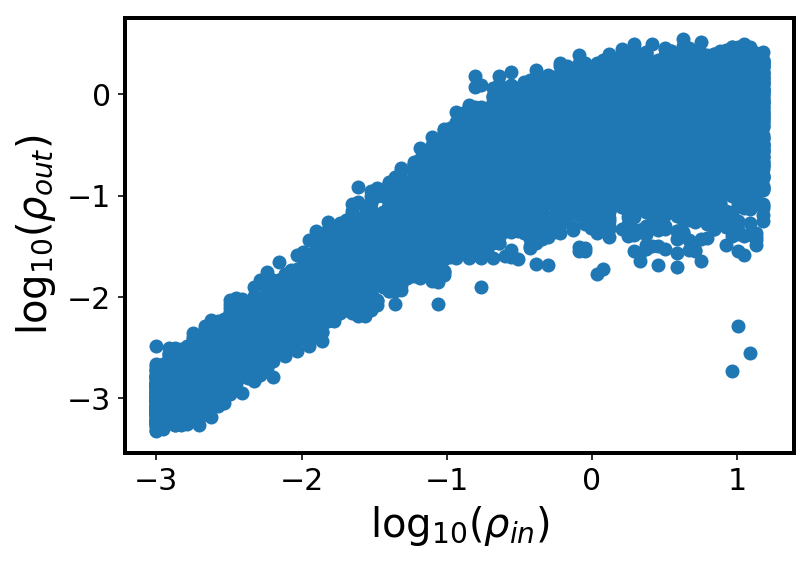

In [63]:
fig,ax = plt.subplots()
ax.scatter(x,y)
ax.set_xlabel(r'$\log_{10}(\rho_{in})$')
ax.set_ylabel(r'$\log_{10}(\rho_{out})$')



Text(0.5, 0, '$\\log_{10}(\\rho_{in})$')

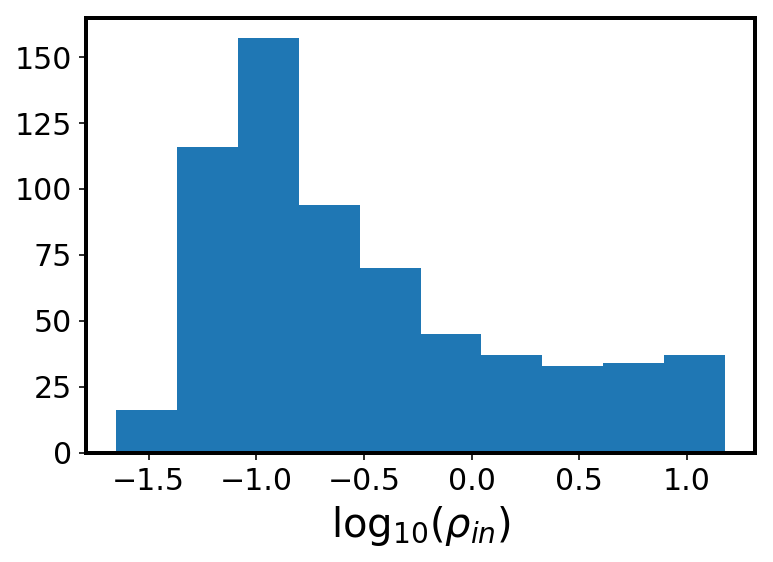

In [65]:
y_probe = -1.
delta  = 0.1 
m = ((y_probe-delta) < y) & (y < (y_probe+ delta))
plt.hist(x[m])
plt.xlabel(r'$\log_{10}(\rho_{in})$')

Take values of y_probe ( rho_out ) from simulated LCs : 

In [21]:
tall = Table.read('../code2/190401_Celerite_sim_w_LSST_ZTF_Jeff1.txt', format='ascii')

In [24]:
fit = 'EXP'
s = 'sdss'
rho_out_sim = tall['tau'+fit+'_'+s] / tall['length_'+s]

In [83]:
perc

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

In [109]:
log_rho_samples

array([-1.4374862 , -1.35678021, -1.29108392, -1.24033762, -1.19800369,
       -1.1611538 , -1.12378153, -1.09415186, -1.06792984, -1.04254427,
       -1.01460627, -0.99386331, -0.97195295, -0.94943722, -0.92685575,
       -0.90588845, -0.88403147, -0.86267384, -0.84692016, -0.82521249,
       -0.80390113, -0.78728966, -0.7697081 , -0.75265982, -0.73587682,
       -0.72014039, -0.70509295, -0.68739949, -0.67064721, -0.65398624,
       -0.6377489 , -0.62049216, -0.60302296, -0.58735879, -0.57043051,
       -0.55084193, -0.53059825, -0.51314954, -0.49679314, -0.47904481,
       -0.45868349, -0.4301156 , -0.40797115, -0.37981352, -0.34633839,
       -0.30959119, -0.26165867, -0.16561597])

In [108]:
rho_out_samples


array([0.03651857, 0.04397641, 0.0511583 , 0.05749928, 0.06338643,
       0.06899954, 0.07520011, 0.08050969, 0.08552049, 0.09066835,
       0.09669271, 0.10142306, 0.10667117, 0.11234734, 0.11834346,
       0.12419713, 0.13060762, 0.13719117, 0.14225903, 0.14955038,
       0.15707204, 0.16319631, 0.16993854, 0.17674217, 0.18370593,
       0.19048449, 0.19720006, 0.20540003, 0.21347783, 0.22182667,
       0.23027728, 0.2396116 , 0.24944628, 0.25860756, 0.2688868 ,
       0.28129244, 0.29471467, 0.30679654, 0.31857146, 0.33186021,
       0.34778953, 0.37143635, 0.39086686, 0.41704842, 0.45046558,
       0.49024007, 0.54744606, 0.68294232])

-1.4374862004429385
-1.356780213850837
-1.2910839236925045
-1.2403376160430584
-1.1980036852136686
-1.1611538049459547
-1.123781531617379
-1.0941518567170343
-1.0679298439101725
-1.0425442673327772
-1.0146062718626307
-0.9938633054177453
-0.9719529463727002
-0.9494372226395957
-0.9268557539424794
-0.9058884473319303
-0.8840314704124863
-0.8626738400512832
-0.8469201554194556
-0.8252124890010835
-0.8039011265834529
-0.7872896600517238
-0.7697081049545634
-0.7526598178429657
-0.735876816421922
-0.7201403856340924
-0.7050929537155157
-0.6873994907200179
-0.6706472121883206
-0.6539862368128069
-0.6377489030852048
-0.6204921611500096
-0.6030229647738827
-0.5873587884537207
-0.5704305149240595
-0.5508419349920423
-0.5305982503693322
-0.5131495443201243
-0.4967931364177415
-0.4790448128251021
-0.4586834929421579
-0.43011560236873564
-0.40797115136071993
-0.37981352010258446
-0.34633838578507375
-0.3095911902260619
-0.2616586676348811
-0.16561597495458671


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


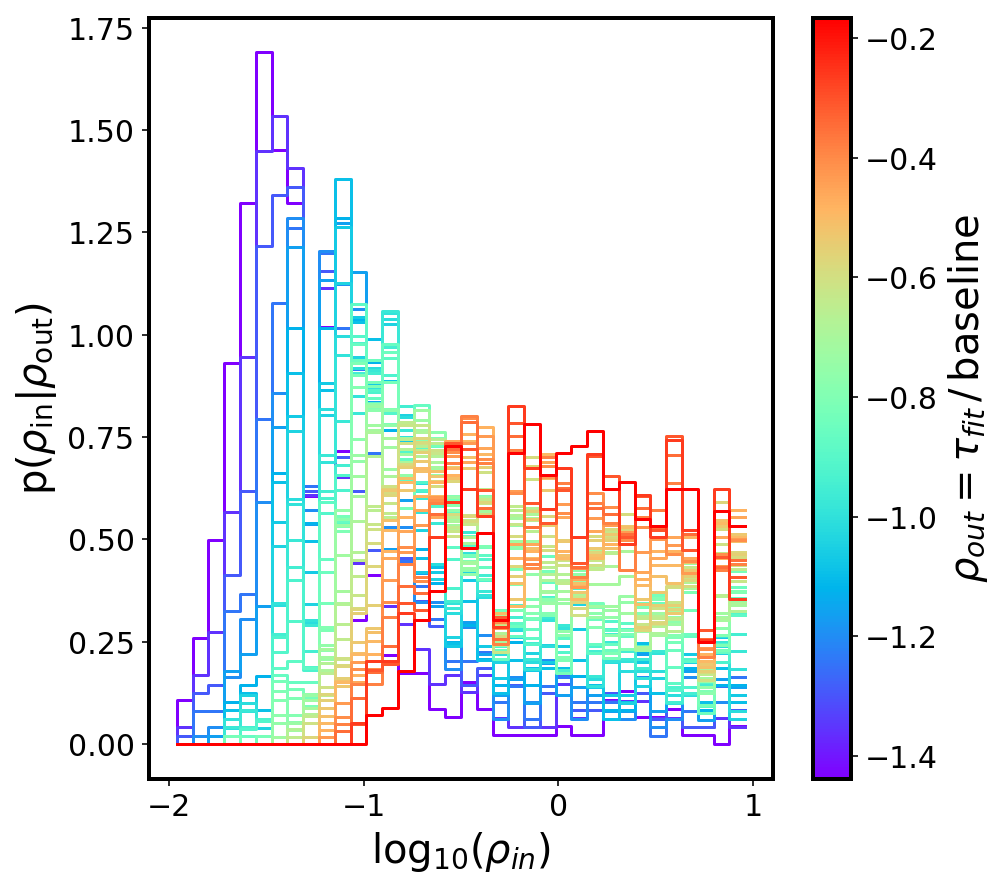

In [128]:
%matplotlib inline

import matplotlib
from matplotlib.pyplot import cm 


fig,ax  = plt.subplots(1,1,figsize=(7,7))

#indices = np.random.choice(np.arange(len(rho_out_sim)), size=N, replace=False)
bins = np.linspace(-2,1,38)
bin_cen = (bins[:-1] + bins[1:]) / 2
    
hist = np.zeros_like(bin_cen)
rho_out_samples = np.percentile(rho_out_sim,np.arange(5,100,2) )
log_rho_samples = np.log10(rho_out_samples)

norm = matplotlib.colors.Normalize(vmin=np.min(log_rho_samples),
                                   vmax=np.max(log_rho_samples))

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=cm.rainbow, 
                                   norm=norm)
s_m.set_array([])

for i in range(len(log_rho_samples)):
    #ind = indices[i]
    # rho_out_ = rho_out_sim[ind]
    log_rho_ = log_rho_samples[i]
    print(log_rho_)
    color = s_m.to_rgba(log_rho_)
    
    y_probe = log_rho_
    delta  = 0.1
    
    m = ((y_probe-delta) < y) & (y < (y_probe+ delta))
    
    hist_i, bin_edges = np.histogram(x[m], bins, normed=True)
    dbin = abs(bin_edges[1] - bin_edges[0])
    ax.plot(bin_cen, hist_i , drawstyle='steps', label='', color=color)
    #ax.plot(bin_cen, hist_i / (np.sum(hist_i)*dbin) , 
    #        drawstyle='steps', label='', color=color)
    
    hist += hist_i
    
hist_norm = hist / hist.sum()
#ax.plot(bin_cen, hist, drawstyle='steps')
ax.set_xlabel(r'$\log_{10}(\rho_{in})$')
plt.colorbar(s_m, label=r'$\rho_{out} = \tau_{fit}\, / \,\mathrm{baseline}$')
ax.set_ylabel('p'+r'$(\rho_{\mathrm{in}} | \rho_{\mathrm{out}})$')
plt.savefig('SDSS_Jeff1_Fig2_slicing_simulated_190401.png', 
            bbox_inches='tight', dpi=100)

Text(0.5, 0, '$\\log_{10}(\\rho_{in})$')

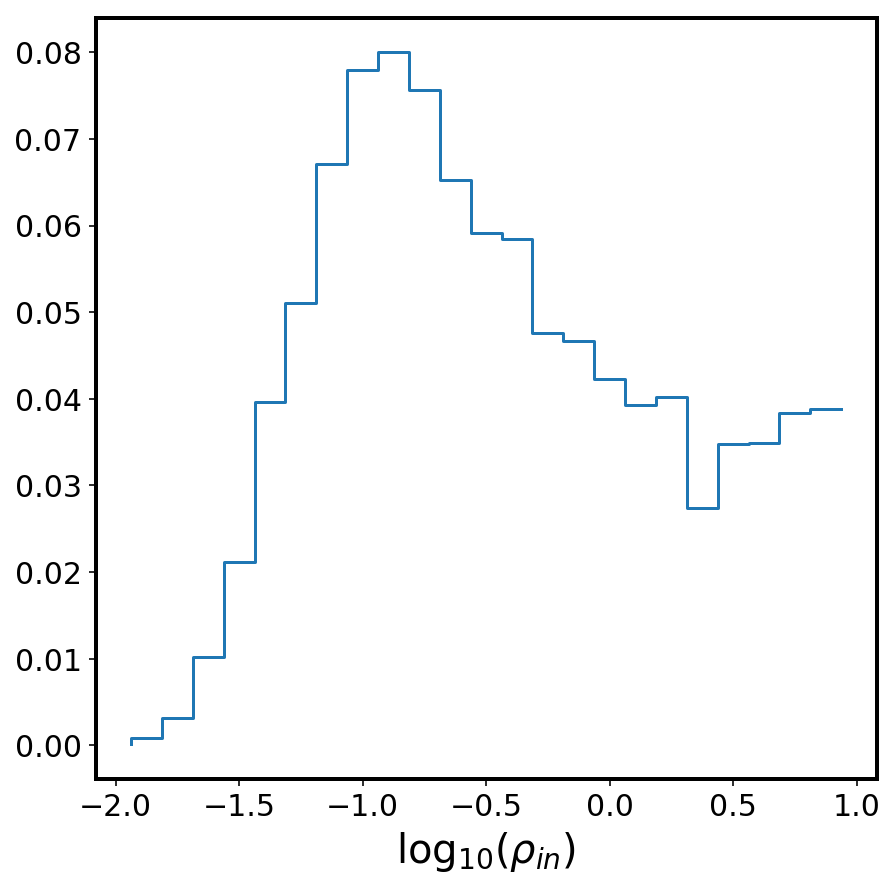

In [68]:
fig,ax  = plt.subplots(1,1,figsize=(7,7))
hist_norm = hist / hist.sum()
ax.plot(bin_cen, hist_norm, drawstyle='steps')
ax.set_xlabel(r'$\log_{10}(\rho_{in})$')

In [71]:
hist_norm.sum()

1.0

In [53]:
plt.plot?

In [47]:
len(hist)

34